# Run the parapactric speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from fastscape.models import basic_model
from fastscape.processes import MultipleFlowRouter

from paraspec.fastscape_ext import ParapatricSpeciation, ParapatricEnvironmentElevation

## Paraspec-LEM model

In [2]:
model = basic_model.update_processes({
    'life_env': ParapatricEnvironmentElevation,
    'life': ParapatricSpeciation,
    'flow': MultipleFlowRouter
})

model

<xsimlab.Model (18 processes, 16 inputs)>
grid
    length          [in] ('shape_yx',) total grid length in (y, x)
    shape           [in] ('shape_yx',) nb. of grid nodes in (y, x)
boundary
    status          [in] () or ('border',) node status at borders
fs_context
uplift
    rate            [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
diffusion
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
init_erosion
flow
    slope_exp       [in] () or ('y', 'x') MFD partioner slope exponent
drainage
spl
    slope_exp       [in] slope exponent
    k_coef          [in] () or ('y', 'x') bedrock channel incision ...
    area_exp        [in] drainage area exponent
erosion
vmotion
topography
terrain
life_env
life
    nb_radius       [in] fixed neighborhood radius
    sigma_mut       [in] controls mutation magnitude
    capacity        [in] population capacity within neighborhood
    random_seed     [in] random number generator seed
    sigma_d         [

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_size': 100,
            'nb_radius': 1e3,
            'capacity': 15,
            'sigma_d': 100.,
            'sigma_mut': 25,
            'sigma_w': 50,
            'random_seed': 1234
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__opt_trait': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

In [5]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'pop')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'pop'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
    # assign tree-specific extra columns
    .assign(
        tree_id=lambda df: df.ptree.tree_id,
        node_type=lambda df: df.ptree.node_type
    )
)


df

,out,pop,id,opt_trait,parent,trait,x,y,tree_id,node_type
id,,,,,,,,,,
0,0.0,0,0,0.212769,0,0.979009,3830.389008,15342.332568,0,root
1,0.0,1,1,0.697048,1,0.881208,12442.175421,14162.307240,1,root
2,0.0,2,2,0.356828,2,0.627673,8754.554780,15937.343675,2,root
3,0.0,3,3,0.246659,3,0.930459,15707.171674,11155.216569,3,root
4,0.0,4,4,0.016239,4,0.724775,15599.516162,19316.730640,4,root
...,...,...,...,...,...,...,...,...,...,...
1650459,990000.0,1681,1650459,165.073862,1633632,146.814030,14595.405109,5496.354852,97,leaf
1650460,990000.0,1682,1650460,131.464888,1633634,36.577684,15123.283591,6083.746892,97,leaf
1650461,990000.0,1683,1650461,138.980625,1633634,137.394280,15095.564744,6150.927579,97,leaf


## Plot population

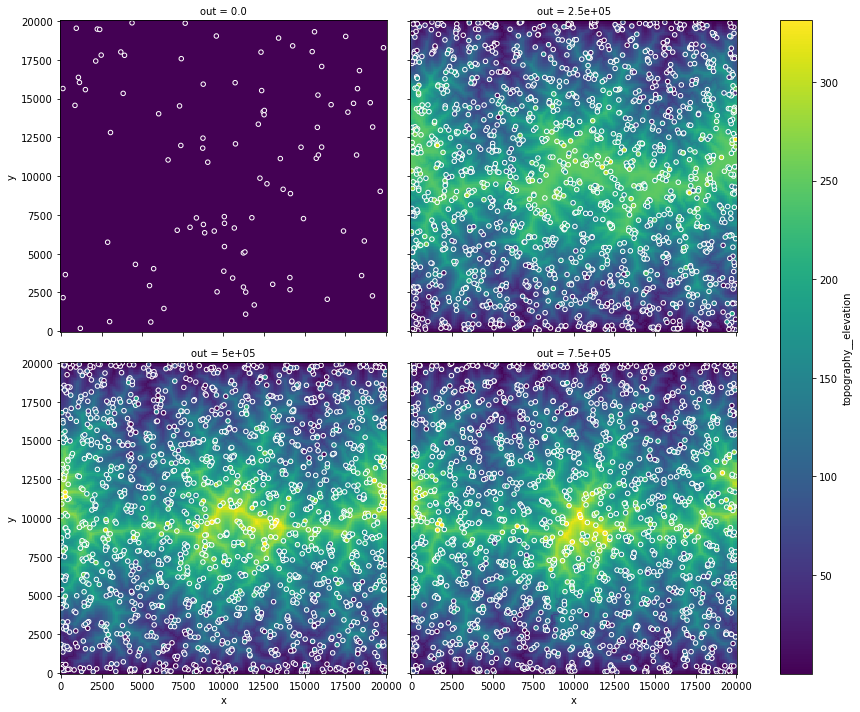

In [6]:
times = np.arange(0, 1e6, 2.5e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait, vmin=0, vmax=elev_max, s=20, edgecolor='w')

## Plot subtree 

In [7]:
def plot_tree(G, pos=None, root=None, alpha=0.5, node_size=40,
              node_color='trait', cmap=plt.cm.viridis,
              edge_color=None, edge_cmap=plt.cm.gray,
              vmin=None, vmax=None, prog='dot', ax='none', fig='none'):

    if pos is None:
        pos = graphviz_layout(G, prog=prog, root=root)
    else:
        x, y = pos
        pos = {k: (v[x], v[y]) for k, v in G.nodes.data()}

    node_data = [n.get(node_color) for n in G.nodes.values()]
    if vmin is None:
        vmin = np.nanmin(node_data)
    if vmax is None:
        vmax = np.nanmax(node_data)

    if edge_color is None:
        edge_data = 'k'
    else:
        edge_data = [e.get(edge_color) for e in G.edges.values()]

    if ax=='none':
        fig, ax = plt.subplots(figsize=(14, 12))


    nx.draw(G, pos=pos, ax=ax, alpha=alpha,
            node_size=node_size, node_color=node_data,
            cmap=cmap, vmin=vmin, vmax=vmax,
            edge_color=edge_data, edge_cmap=edge_cmap)

    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))

    sm.set_array([])
    
    cbar = plt.colorbar(sm, fraction=0.025, pad=0.04)

    return fig, ax

In [8]:
tree_id = df.tree_id.value_counts().idxmax()  # find root with largest tree
leaf = df[(df.tree_id==tree_id) & (df.out==df.out.max())].id  # end nodes (leaf) of tree_id

# define subtree (dataframe and networkx)
df_tree = (
    df
    .ptree.merge_forest(-1)
    .ptree.drop_disconnected_roots()
    .ptree.extract_subtree(leaf=list(leaf))
)

G = df_tree.ptree.to_networkx(node_col='trait')

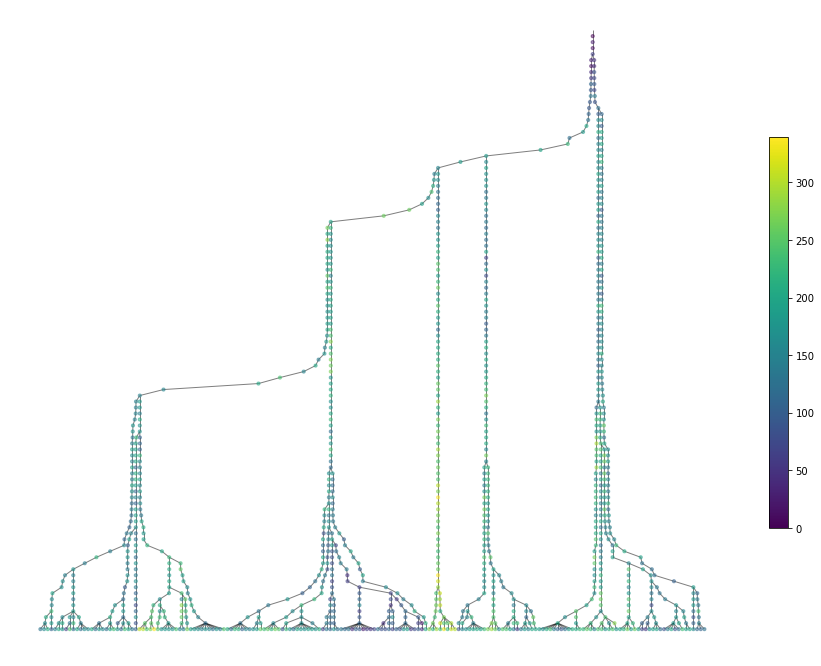

In [9]:
plot_tree(G, prog='dot', node_color='trait', node_size=10, cmap=plt.cm.viridis,
          vmin=0, vmax=elev_max);